# Acrobot Direct Collocation Demo

In [1]:
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import numpy as np
import os
from pathlib import Path
import time
import control
import cyipopt

In [8]:
import jax
import jax.numpy as jnp

def acrobot_dynamics(x, u, params):
    th1, th2, dth1, dth2 = x
    tau = u[0]

    m1 = params['m1']
    m2 = params['m2']
    l1 = params['l1']
    l2 = params['l2']
    lc1= params['lc1']
    lc2= params['lc2']
    I1 = params['I1']
    I2 = params['I2']
    g  = params['g']

    s2 = jnp.sin(th2)
    c2 = jnp.cos(th2)

    d11 = I1 + I2 + m2*l1**2 + 2.0*m2*l1*lc2*c2
    d12 = I2 + m2*l1*lc2*c2
    d21 = d12
    d22 = I2 + m2*lc2**2
    M = jnp.array([[d11, d12],
                   [d21, d22]])

    h  = -m2*l1*lc2*s2
    c1 = h*dth2*(2.0*dth1 + dth2)
    c2 = -h*dth1**2

    phi2 = m2*lc2*g*jnp.cos(th1+th2 - jnp.pi/2)
    phi1 = (m1*lc1 + m2*l1)*g*jnp.cos(th1 - jnp.pi/2) + phi2

    b1 = -c1 - phi1
    b2 = tau - c2 - phi2
    b  = jnp.array([b1, b2])

    dd = jnp.linalg.solve(M, b)
    ddth1, ddth2 = dd[0], dd[1]

    return jnp.array([dth1, dth2, ddth1, ddth2])

# Build derivatives, JIT them
dfdx_jax = jax.jit(
    jax.jacobian(lambda x, u, p: acrobot_dynamics(x, u, p), argnums=0)
)
dfdu_jax = jax.jit(
    jax.jacobian(lambda x, u, p: acrobot_dynamics(x, u, p), argnums=1)
)

# Example usage:
def test_jax_acrobot():
    params = {
        'm1': 1.0, 'm2': 1.0,
        'l1': 1.0, 'l2': 1.0,
        'lc1':0.5, 'lc2':0.5,
        'I1':1.0,  'I2':1.0,
        'g':9.81
    }

    x = jnp.array([0.0, 0.0, 1.0, 0.0])
    u = jnp.array([0.5])

    # Evaluate f
    fx = acrobot_dynamics(x, u, params)
    print("f(x,u) =", fx)

    # Evaluate derivatives
    dfdx_val = dfdx_jax(x, u, params)
    dfdu_val = dfdu_jax(x, u, params)
    print("df/dx =", dfdx_val)  # shape (4,4)
    print("df/du =", dfdu_val)  # shape (4,1)

if __name__ == "__main__":
    test_jax_acrobot()


f(x,u) = [ 1.          0.         -0.27272704  0.7272726 ]
df/dx = [[ 0.         0.         1.         0.       ]
 [ 0.         0.         0.         1.       ]
 [-6.2427278  0.7186364  0.         0.       ]
 [ 3.5672731 -5.186364   0.         0.       ]]
df/du = [[ 0.        ]
 [ 0.        ]
 [-0.54545456]
 [ 1.4545455 ]]


In [17]:
#!/usr/bin/env python
import sympy

# Define symbolic variables
# State: th1, th2, dth1, dth2
th1, th2, dth1, dth2 = sympy.symbols('th1 th2 dth1 dth2', real=True)
# Control: torque (tau)
tau = sympy.Symbol('tau', real=True)

# Physical parameters (could also be made Symbols if you want them variable)
m1, m2  = sympy.symbols('m1 m2', real=True, positive=True)
l1, l2  = sympy.symbols('l1 l2', real=True, positive=True)
lc1, lc2= sympy.symbols('lc1 lc2', real=True, positive=True)
I1, I2  = sympy.symbols('I1 I2', real=True, positive=True)
g       = sympy.Symbol('g', real=True, positive=True)

# For convenience, define sin/cos of th2
s2 = sympy.sin(th2)
c2 = sympy.cos(th2)

# Inertia terms
d11 = I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2
d12 = I2 + m2*l1*lc2*c2
d21 = d12
d22 = I2 + m2*lc2**2

# M = [ [d11, d12],
#       [d21, d22] ]
M = sympy.Matrix([[d11, d12],
                  [d21, d22]])

# Coriolis / gravitational terms
# We'll define the same "h, c1, c2, phi1, phi2" logic as typical Acrobot.
h = -m2*l1*lc2*s2
c1 = h*dth2*(2*dth1 + dth2)
c2 = -h*dth1**2

phi2 = m2*lc2*g*sympy.cos(th1+th2 - sympy.pi/2)
phi1 = (m1*lc1 + m2*l1)*g*sympy.cos(th1 - sympy.pi/2) + phi2

b1 = -c1 - phi1
b2 = tau - c2 - phi2

b = sympy.Matrix([b1, b2])

# Solve for ddth1, ddth2 = M^-1 * b
dd = M.LUsolve(b)
ddth1, ddth2 = dd[0], dd[1]

# The continuous dynamics f(x,u) = [dth1, dth2, ddth1, ddth2].
f1 = dth1
f2 = dth2
f3 = ddth1
f4 = ddth2

f = sympy.Matrix([f1, f2, f3, f4])

# Now we compute Jacobians
x_vars = (th1, th2, dth1, dth2)
u_vars = (tau,)

dfdx_sym = f.jacobian(x_vars)
dfdu_sym = f.jacobian(u_vars)

# Optionally, simplify
dfdx_simpl = sympy.simplify(dfdx_sym)
dfdu_simpl = sympy.simplify(dfdu_sym)

print("=== f(x,u) Symbolic ===")
print("f =\n", f)
print("\n=== df/dx Symbolic ===")
print(dfdx_simpl)
print("\n=== df/du Symbolic ===")
print(dfdu_simpl)

# Create numeric lambda functions
# We'll pass all parameters (m1,m2,l1,l2,lc1,lc2,I1,I2,g) so you can define them at runtime.
all_vars = (th1, th2, dth1, dth2, tau, m1, m2, l1, l2, lc1, lc2, I1, I2, g)
f_func   = sympy.lambdify(all_vars, f, "numpy")
dfdx_func= sympy.lambdify(all_vars, dfdx_simpl, "numpy")
dfdu_func= sympy.lambdify(all_vars, dfdu_simpl, "numpy")

# Demonstrate usage
test_vals = (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 9.81)
f_val = f_func(*test_vals)
dfdx_val = dfdx_func(*test_vals)
dfdu_val = dfdu_func(*test_vals)

print("\n=== Sample numeric evaluation at (th1=0,th2=0,dth1=0,dth2=0,tau=1) ===")
print("f =", f_val)
print("df/dx =", dfdx_val)
print("df/du =", dfdu_val)




=== f(x,u) Symbolic ===
f =
 Matrix([[dth1], [dth2], [(dth2*l1*lc2*m2*(2*dth1 + dth2)*sin(th2) - g*lc2*m2*sin(th1 + th2) - g*(l1*m2 + lc1*m1)*sin(th1) - (I2 + l1*lc2*m2*cos(th2))*(-dth1**2*l1*lc2*m2*sin(th2) - g*lc2*m2*sin(th1 + th2) + tau - (I2 + l1*lc2*m2*cos(th2))*(dth2*l1*lc2*m2*(2*dth1 + dth2)*sin(th2) - g*lc2*m2*sin(th1 + th2) - g*(l1*m2 + lc1*m1)*sin(th1))/(I1 + I2 + l1**2*m2 + 2*l1*lc2*m2*cos(th2)))/(I2 + lc2**2*m2 - (I2 + l1*lc2*m2*cos(th2))**2/(I1 + I2 + l1**2*m2 + 2*l1*lc2*m2*cos(th2))))/(I1 + I2 + l1**2*m2 + 2*l1*lc2*m2*cos(th2))], [(-dth1**2*l1*lc2*m2*sin(th2) - g*lc2*m2*sin(th1 + th2) + tau - (I2 + l1*lc2*m2*cos(th2))*(dth2*l1*lc2*m2*(2*dth1 + dth2)*sin(th2) - g*lc2*m2*sin(th1 + th2) - g*(l1*m2 + lc1*m1)*sin(th1))/(I1 + I2 + l1**2*m2 + 2*l1*lc2*m2*cos(th2)))/(I2 + lc2**2*m2 - (I2 + l1*lc2*m2*cos(th2))**2/(I1 + I2 + l1**2*m2 + 2*l1*lc2*m2*cos(th2)))]])

=== df/dx Symbolic ===
Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [-g*(I2*l1*m2*cos(th1) + I2*lc1*m1*cos(th1) + l1*lc2**2*m2**2*

In [20]:
class AcrobotHermiteSimpson:
    """
    Direct collocation for the Acrobot with a 3rd-order Hermite–Simpson spline.
    State x = (theta1, theta2, dtheta1, dtheta2).
    Control is the torque on the second joint.
    """

    def __init__(self,
                 N=20,         # number of segments
                 dt=0.05,      # time step for each segment
                 x0=None,
                 xT=None,
                 w_final=100.0,
                 w_control=0.1,
                 w_int = 1.0,       # intermediate-state weight
                 x_ref = np.zeros(4)):  # reference state for each node
                
        """
        :param N: number of Hermite–Simpson segments
        :param dt: duration for each segment
        :param x0: initial state (4D)
        :param xT: target final state (4D)
        :param w_final: weight on final-state error
        :param w_control: weight on sum of squared controls
        """
        self.N = N
        self.dt = dt
        self.state_dim = 4  # (th1, th2, dth1, dth2)
        self.nu = 1         # single torque
        self.w_final = w_final
        self.w_control = w_control
        self.w_int = w_int
        self.x_ref = x_ref
        # Default initial and final states:
        self.x0 = np.zeros(4) if x0 is None else x0
        self.xT = np.array([np.pi, 0, 0, 0]) if xT is None else xT

        # Physical parameters
        self.m1 = 1.0
        self.m2 = 1.0
        self.l1 = 1.0
        self.l2 = 1.0
        self.lc1 = 0.5
        self.lc2 = 0.5
        self.I1 = 1.0
        self.I2 = 1.0
        self.g  = 9.81

        self.params = {
            'm1': 1.0, 'm2': 1.0,
            'l1': 1.0, 'l2': 1.0,
            'lc1':0.5, 'lc2':0.5,
            'I1':1.0,  'I2':1.0,
            'g':9.81
        }
        # store references to JAXed derivatives
        self.f = jax.jit(acrobot_dynamics)
        self.dfdx = dfdx_jax
        self.dfdu = dfdu_jax

        # Hermite–Simpson dimensioning:
        # For N segments, we have (2*N + 1) state nodes: x_0, x_0.5, x_1, x_1.5, ..., x_{N-1}, x_{N-1.5}, x_N
        self.num_states = (2*self.N + 1)*self.state_dim

        # We'll define a control at each knot => (N+1) controls
        self.num_controls = (self.N + 1)*self.nu

        self.num_vars = self.num_states + self.num_controls

        # 2 vector constraints per segment => 2*N blocks of size 4 => total 8*N
        self.num_constraints = 2*self.N*self.state_dim


    # ---------------------------
    # Splitting the decision vars
    # ---------------------------
    def _split_vars(self, z):
        """
        z in R^(num_vars). We'll interpret the first (2N+1)*state_dim as X,
        the next (N+1)*nu as U.

        Return:
          X => shape (2N+1, 4)
          U => shape (N+1, 1)
        """
        X = z[:self.num_states].reshape((2*self.N + 1, self.state_dim))
        U = z[self.num_states:].reshape((self.N + 1, self.nu))
        return X, U

    # ---------------------------
    # Acrobot continuous dynamics
    # ---------------------------

    # def forward_dynamics(self, x, u):
    #     return self.f(x, u, self.params)

    # def forward_dynamics_jacobian(self, x, u):
    #     # each is shape (4,4) or (4,1)
    #     dfdx_val = self.dfdx(x, u, self.params)
    #     dfdu_val = self.dfdu(x, u, self.params)
    #     return dfdx_val, dfdu_val
    def forward_dynamics(self, x, u):
        th1, th2, dth1, dth2 = x
        tau = u[0]
        return np.squeeze(f_func(th1, th2, dth1, dth2, tau,
                      self.m1, self.m2, self.l1, self.l2, 
                      self.lc1, self.lc2, self.I1, self.I2, self.g))


    def forward_dynamics_jacobian(self, x, u):
        th1, th2, dth1, dth2 = x
        tau = u[0]
        dfdx_val = np.squeeze(dfdx_func(th1, th2, dth1, dth2, tau,
                             self.m1, self.m2, self.l1, self.l2,
                             self.lc1, self.lc2, self.I1, self.I2, self.g))
        dfdu_val = np.squeeze(dfdu_func(th1, th2, dth1, dth2, tau,
                             self.m1, self.m2, self.l1, self.l2,
                             self.lc1, self.lc2, self.I1, self.I2, self.g))
        return dfdx_val, dfdu_val

        # ---------------------------
    # Acrobot continuous dynamics
    # ---------------------------
    # def forward_dynamics(self, x, u):
    #     """
    #     x = (th1, th2, dth1, dth2), u=[tau].
    #     returns dx/dt = [dth1, dth2, ddth1, ddth2].
    #     """
    #     th1, th2, dth1, dth2 = x
    #     tau = u[0]
    #     m1, m2 = self.m1, self.m2
    #     l1, l2 = self.l1, self.l2
    #     lc1, lc2 = self.lc1, self.lc2
    #     I1, I2 = self.I1, self.I2
    #     g = self.g

    #     s2 = np.sin(th2)
    #     c2 = np.cos(th2)

    #     # Inertia terms
    #     d11 = I1 + I2 + m2*l1**2 + 2.0*m2*l1*lc2*c2
    #     d12 = I2 + m2*l1*lc2*c2
    #     d21 = d12
    #     d22 = I2 + m2*lc2**2

    #     dd = np.array([[d11, d12],
    #                    [d21, d22]])

    #     # Coriolis, gravitational terms
    #     h = -m2*l1*lc2*s2
    #     c1 =  h*dth2*(2.0*dth1 + dth2)
    #     c2 = -h*dth1**2
    #     phi2 = m2*lc2*g*np.cos(th1+th2 - np.pi/2)
    #     phi1 = (m1*lc1 + m2*l1)*g*np.cos(th1 - np.pi/2) + phi2

    #     b1 = -c1 - phi1
    #     b2 = tau - c2 - phi2

    #     # dd_inv = np.linalg.inv(dd)
    #     ddth = np.linalg.solve(dd, np.array([b1, b2]))
    #     ddth1, ddth2 = ddth
    #     return np.array([dth1, dth2, ddth1, ddth2], dtype=float)

    # def forward_dynamics_jacobian(self, x, u):
    #     """
    #     Return (df/dx, df/du). Each has shape:
    #        dfdx: (4,4)
    #        dfdu: (4,1)
    #     for the Acrobot. 
    #     For brevity, let's do a small finite difference here. 
    #     In real usage, you'd likely do a symbolic or autodiff approach.
    #     """
    #     eps = 1e-6
    #     f0 = self.forward_dynamics(x, u)

    #     dfdx = np.zeros((4,4))
    #     for i in range(4):
    #         x_pert = x.copy()
    #         x_pert[i] += eps
    #         f_pert = self.forward_dynamics(x_pert, u)
    #         dfdx[:, i] = (f_pert - f0)/eps

    #     dfdu = np.zeros((4,1))
    #     u_pert = u.copy()
    #     u_pert[0] += eps
    #     f_pert = self.forward_dynamics(x, u_pert)
    #     dfdu[:,0] = (f_pert - f0)/eps

    #     return dfdx, dfdu
    # ---------------------------
    # Hermite–Simpson constraints
    # ---------------------------
    def constraints(self, z):
        """
        For each segment k=0..N-1, define:
         x_k   = X[2k],   x_{k+1/2} = X[2k+1],  x_{k+1} = X[2(k+1)]
         u_k   = U[k],    u_k1 = U[k+1],       u_mid = 0.5*(u_k + u_k1)

         f_k = f(x_k, u_k), 
         f_mid = f(x_mid, u_mid),
         f_k1 = f(x_{k+1}, u_k1)

         (1) x_{k+1} - x_k = (dt/6) [ f_k + 4 f_mid + f_k1 ]
         (2) x_{k+1/2} = 0.5(x_k + x_{k+1}) + (dt/8)[ f_k - f_k1 ]
        We'll stack them in a single 1D array of length 2*N*4.
        """
        X, U = self._split_vars(z)
        con = np.zeros(self.num_constraints)
        idx = 0

        for k in range(self.N):
            xk    = X[2*k]
            xmid  = X[2*k + 1]
            xk1   = X[2*(k+1)]
            uk    = U[k]
            uk1   = U[k+1]
            umid  = 0.5*(uk + uk1)

            fk    = self.forward_dynamics(xk,   uk)
            fmid  = self.forward_dynamics(xmid, umid)
            fk1   = self.forward_dynamics(xk1,  uk1)
            # print(np.shape((self.dt/6.0)*(fk + 4.0*fmid + fk1)))
            # print(np.shape(xk1))
            # (1) x_{k+1} - x_k - (dt/6)*(f_k + 4 f_mid + f_k1) = 0
            c1 = xk1 - xk - (self.dt/6.0)*(fk + 4.0*fmid + fk1)
            con[idx:idx+4] = c1
            idx += 4

            # (2) x_{k+0.5} - 0.5(x_k + x_{k+1}) - (dt/8)*(f_k - f_k1) = 0
            c2 = xmid - 0.5*(xk + xk1) - (self.dt/8.0)*(fk - fk1)
            con[idx:idx+4] = c2
            idx += 4

        return con

    # ---------------------------
    # Objective
    # ---------------------------
    def objective(self, z):
        """
        Cost = 
          sum_{k=0..N} of w_control * ||u_k||^2
        + w_final * || X[2N] - xT ||^2
        + w_int * sum_{i=0..2N} || X[i] - x_ref ||^2   (new intermediate cost)
        """
        X, U = self._split_vars(z)
        cost = 0.0
    
        # 1) Control cost
        for k in range(self.N+1):
            cost += self.w_control*(U[k,0]**2)
    
        # 2) Final state cost
        x_final = X[2*self.N]
        diff_final = x_final - self.xT
        cost += self.w_final * (diff_final @ diff_final)
    
        # 3) Intermediate state cost (new)
        for i in range(2*self.N + 1):
            diff = X[i] - self.x_ref
            cost += self.w_int * (diff @ diff)
    
        return cost
    
    
    def gradient(self, z):
        """
        Gradient of the cost w.r.t. all decision variables, incorporating:
          - partial wrt controls:  2 * w_control * U[k]
          - partial wrt final state: 2 * w_final * (x_final - xT)
          - partial wrt each X[i] for the intermediate cost: 2 * w_int * (X[i] - x_ref)
        """
        grad = np.zeros(self.num_vars)
        X, U = self._split_vars(z)
    
        # partial wrt controls
        for k in range(self.N+1):
            grad[self.num_states + k] = 2.0*self.w_control*U[k,0]
    
        # partial wrt final state X[2N]
        x_final = X[2*self.N]
        diff_final = x_final - self.xT
        g_final = 2.0*self.w_final * diff_final
        off_xfinal = (2*self.N)*self.state_dim
        grad[off_xfinal : off_xfinal + self.state_dim] += g_final
    
        # partial wrt intermediate states (new)
        for i in range(2*self.N + 1):
            diff = X[i] - self.x_ref
            g_i = 2.0 * self.w_int * diff
            off_xi = i*self.state_dim
            grad[off_xi : off_xi + self.state_dim] += g_i
    
        return grad


    # ---------------------------
    # Jacobian of constraints
    # ---------------------------
    def jacobian(self, z):
        """
        For each segment k, we have c1, c2:

          c1 = x_{k+1} - x_k - (dt/6)*(f_k + 4 f_mid + f_k1)
          c2 = x_mid - 0.5(x_k + x_{k+1}) - (dt/8)*(f_k - f_k1)

        We'll fill a [2*N*4, num_vars] Jacobian matrix.
        We'll rely on chain rule, partials of f wrt x, u, and partials 
        of x_mid wrt (u_k, u_k1) => 0.5 factor for the midpoint control, etc.
        """
        X, U = self._split_vars(z)
        J = np.zeros((self.num_constraints, self.num_vars))

        row_idx = 0
        loop_start = time.time()
        fwd_time = 0
        jac_time = 0
        for k in range(self.N):
            # Indices in X array
            i_xk    = 2*k
            i_xmid  = 2*k + 1
            i_xk1   = 2*(k+1)

            off_xk    = i_xk*self.state_dim
            off_xmid  = i_xmid*self.state_dim
            off_xk1   = i_xk1*self.state_dim

            # Indices in U array
            off_uk   = self.num_states + k
            off_uk1  = self.num_states + (k+1)

            xk   = X[i_xk]
            xmid = X[i_xmid]
            xk1  = X[i_xk1]
            uk   = U[k]
            uk1  = U[k+1]

            umid = 0.5*(uk + uk1)
            fwd_start = time.time()
            fk   = self.forward_dynamics(xk,   uk)
            fmid = self.forward_dynamics(xmid, umid)
            fk1  = self.forward_dynamics(xk1,  uk1)
            fwd_time += time.time() - fwd_start
            # partial derivatives of f wrt x,u
            jac_start = time.time()
            dfdx_k,   dfdu_k   = self.forward_dynamics_jacobian(xk,   uk)
            dfdx_mid, dfdu_mid = self.forward_dynamics_jacobian(xmid, umid)
            dfdx_k1,  dfdu_k1  = self.forward_dynamics_jacobian(xk1,  uk1)
            jac_time += time.time() - jac_start

            # 1) c1 row range
            row_c1 = slice(row_idx, row_idx+4)
            row_idx += 4
            # 2) c2 row range
            row_c2 = slice(row_idx, row_idx+4)
            row_idx += 4

            # c1 = x_{k+1} - x_k - (dt/6)(f_k + 4f_mid + f_k1)
            # partial c1 wrt x_{k+1}: +I
            J[row_c1, off_xk1: off_xk1+4] += np.eye(4)
            # partial c1 wrt x_k: -I - (dt/6)*df_k/dx
            J[row_c1, off_xk: off_xk+4] -= np.eye(4)
            J[row_c1, off_xk: off_xk+4] -= (self.dt/6.0)*dfdx_k
            # partial c1 wrt x_mid: - (dt/6)*4*dfdx_mid
            J[row_c1, off_xmid: off_xmid+4] -= (self.dt/6.0)*4.0*dfdx_mid
            # partial c1 wrt x_{k+1}: - (self.dt/6)*dfdx_k1
            #    we already have +I from above, so we add this derivative:
            J[row_c1, off_xk1: off_xk1+4] -= (self.dt/6.0)*dfdx_k1

            # partial c1 wrt u_k => -(dt/6)*dfdu_k
            J[row_c1, off_uk] -= (self.dt/6.0)*dfdu_k.reshape(4)
            # partial c1 wrt u_k1 => -(dt/6)*dfdu_k1
            J[row_c1, off_uk1] -= (self.dt/6.0)*dfdu_k1.reshape(4)
            # partial c1 wrt u_mid => -(dt/6)*4 dfdu_mid * partial(u_mid)/partial(uk,uk1)
            #   u_mid = 0.5 (uk + uk1) => partial wrt uk => 0.5, wrt uk1 => 0.5
            # so for u_k:
            J[row_c1, off_uk] -= (self.dt/6.0)*4.0*(0.5)*dfdu_mid.reshape(4)
            # and for u_k1:
            J[row_c1, off_uk1] -= (self.dt/6.0)*4.0*(0.5)*dfdu_mid.reshape(4)

            # c2 = x_mid - 0.5(x_k + x_{k+1}) - (dt/8)(f_k - f_k1)
            # partial c2 wrt x_mid => +I
            J[row_c2, off_xmid: off_xmid+4] += np.eye(4)
            # partial c2 wrt x_k => -0.5I - (dt/8)*df_k/dx
            J[row_c2, off_xk: off_xk+4] -= 0.5*np.eye(4)
            J[row_c2, off_xk: off_xk+4] -= (self.dt/8.0)*dfdx_k
            # partial c2 wrt x_{k+1} => -0.5I + (dt/8)*df_k1/dx
            J[row_c2, off_xk1: off_xk1+4] -= 0.5*np.eye(4)
            J[row_c2, off_xk1: off_xk1+4] += (self.dt/8.0)*dfdx_k1

            # partial c2 wrt u_k => -(dt/8)*dfdu_k
            J[row_c2, off_uk] -= (self.dt/8.0)*dfdu_k.reshape(4)
            # partial c2 wrt u_k1 => +(dt/8.0)*dfdu_k1
            J[row_c2, off_uk1] += (self.dt/8.0)*dfdu_k1.reshape(4)

            # no direct dependence on f_mid in c2, so no partial wrt u_mid there.
        # print('Loop time', time.time() - loop_start)
        # print('fwd time', fwd_time)
        # print('jac time', jac_time)
        return J

    # ---------------------------
    # Hessian
    # ---------------------------
    def hessian(self, x, lagrange, obj_factor):
        return None  # let IPOPT do BFGS or limited-memory

    # ---------------------------
    # Solve
    # ---------------------------
    def solve(self, guess=None, verbose=True):
        if guess is None:
            guess = self.initial_guess()

        # Bounds
        lb = -np.inf*np.ones(self.num_vars)
        ub =  np.inf*np.ones(self.num_vars)
        # fix X[0] = x0
        for i in range(4):
            lb[i] = self.x0[i]
            ub[i] = self.x0[i]

        # constraints => 0
        cl = np.zeros(self.num_constraints)
        cu = np.zeros(self.num_constraints)

        nlp = cyipopt.Problem(
            n=self.num_vars,
            m=self.num_constraints,
            problem_obj=self,
            lb=lb, ub=ub,
            cl=cl, cu=cu
        )
        nlp.add_option('print_level', 5 if verbose else 0)
        nlp.add_option('max_iter', 5000)
        nlp.add_option('tol', 1e-6)
        nlp.add_option('hessian_approximation', 'limited-memory')

        x, sol = nlp.solve(guess)
        return sol

    def initial_guess(self):
        """
        Simple guess: linearly interpolate the knot states from x0->xT,
        fill midpoints as average, set controls to zero.
        """
        # X in shape (2N+1, 4)
        X_guess = np.zeros((2*self.N+1, 4))
        for k in range(self.N+1):
            alpha = k/self.N
            x_knot = (1-alpha)*self.x0 + alpha*self.xT
            X_guess[2*k] = x_knot
        # midpoints
        for k in range(self.N):
            X_guess[2*k + 1] = 0.5*(X_guess[2*k] + X_guess[2*k + 2])

        U_guess = np.zeros((self.N+1, 1))

        return np.concatenate([X_guess.ravel(), U_guess.ravel()])

    # Required by cyipopt.Problem:
    def objective_fun(self, z):
        return self.objective(z)
    def constraint_fun(self, z):
        return self.constraints(z)


In [21]:
def demo_acrobot_hs():
    # Start: downward
    x0 = np.array([0.0, 0.0, 0.0, 0.0])
    # Goal: "up" at pi on first joint, zero everything else
    xT = np.array([np.pi, 0.0, 0.0, 0.0])

    problem = AcrobotHermiteSimpson(
        N=70,
        dt=0.1,
        x0=x0,
        xT=xT,
        w_final=1.0,
        w_control=0.01,
        w_int=1.0,
        x_ref=xT
    )

    res = problem.solve(verbose=True)
    print("Solver status:", res['status'])
    print("Solver msg:", res.get('status_msg', '???'))
    print("Final cost:", res['obj_val'])

    z_opt = res['x']
    X_opt, U_opt = problem._split_vars(z_opt)
    print("Last knot state:", X_opt[2*problem.N])
    print("Some controls:", U_opt[:5].flatten())

    return X_opt, U_opt


if __name__ == "__main__":
    X_sol, U_sol = demo_acrobot_hs()


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   353360
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      631
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      560
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.6552809e+02 6.24e-01 1.07e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [22]:
# Example references
model_name = "double_pendulum"
model_xml_path = Path("mujoco_models") / (str(model_name) + ".xml")

os.environ["MUJOCO_GL"] = "egl"
model = mujoco.MjModel.from_xml_path(str(model_xml_path.absolute()))
data = mujoco.MjData(model)

In [23]:

def set_state(model, data, x):
    """
    Utility that sets the MuJoCo state from x = [qpos; qvel].
    """
    nq = model.nq
    nv = model.nv
    data.qpos[:] = x[:nq]
    data.qvel[:] = x[nq:nq+nv]
    mujoco.mj_forward(model, data)

def simulate_with_viewer(model, data, X, U, dt=0.01, substeps=1):
    """
    Forward-simulate the system in a MuJoCo viewer using the provided trajectory (X, U).
    - model, data: MuJoCo model and data
    - X: Nx x (H+1) array of states [qpos; qvel; ...]
    - U: Nu x H array of controls
    - dt: time step for each control
    - substeps: how many mj_step calls to simulate each dt

    This function sets the state to X[:,k], applies U[:,k] as control,
    and steps the simulation for 'substeps' times, rendering at each step.
    """
    # Number of time steps
    data.qpos = [np.pi, 0]
    data.qvel = [0, 0]
    X_plot = X_sol.copy()
    X_plot[:,0] = - X_plot[:,0] + np.pi
    N = np.shape(X_plot)[0]
    print(N)
    with mujoco.viewer.launch_passive(model, data) as viewer:
        for k in range(N):
        
            # Place the simulation at X[:, k]
            # set_state(model, data, X[:, k])
    
            # Apply control
            # u = get_control_from_trajectory(U, data.time, dt)
            # data.ctrl[:] = u
            mujoco.mj_step(model, data)
            
            data.qpos = X_plot[k,:2]
            
            # Step the simulation substeps times
            for _ in range(substeps):
                # mujoco.mj_step(model, data)
                viewer.sync()
                # Sleep so that the simulation doesn't fly by too quickly
                time.sleep(dt / substeps/2)
    
        # Final state: place the simulator at X[:, horizon]
        # set_state(model, data, X[:, horizon])
        
    #     # Keep the final state visible for a moment
        time.sleep(1.0)
    
    # # Close the viewer
        viewer.close()
        
def get_control_from_trajectory(U_opt, current_time, dt):
    """
    Return the appropriate control from U_opt at the given current_time,
    assuming piecewise-constant controls of duration dt.

    :param U_opt: array of shape (N+1, nu), the optimized control sequence
    :param current_time: current simulation time (e.g. data.time in MuJoCo)
    :param dt: the time step used in the optimization
    :return: 1D array of shape (nu,) with the chosen control
    """
    # Number of discrete control segments = len(U_opt) - 1
    # The index k in [0, N] where current_time falls
    k = int(current_time // dt)

    # Clamp k if time is beyond the planned horizon
    k = min(k, len(U_opt) - 1)

    return U_opt[k]


In [29]:
simulate_with_viewer(model, data, X_sol, U_sol, dt=0.1, substeps=1)

141


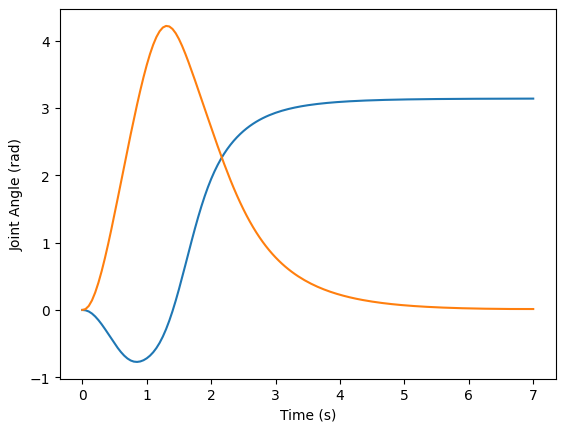

NameError: name 'U_opt' is not defined

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
plt.figure()
H = 70
dt = 0.1
times = np.arange(0, (H + 0.5) * dt, dt/2)
plt.plot(times, X_sol[:, 0], label='State 1')
plt.plot(times, X_sol[:, 1], label='State 2')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.show()

plt.figure()
plt.plot(times[:-1], U_sol.T, label='Input 1')
plt.xlabel('Time (s)')
plt.ylabel('Input (Nm)')
plt.show()
